In [112]:
##HELPER FUNCTIONS

import numpy as np

#params
#-vi: non-reduced lattice vector
#-vj_star: graham schmidt reduced lattice vector
#returns: the quantity u_ij
def get_u(vi, vj_star):
    dot_ij = dot(vi, vj_star)
    mag_j = abs(dot(vj_star, vj_star))
    u_ij = dot_ij / mag_j
    return u_ij

#returns: the dot product of two vectors: in this case, a sum over elementwise multiplication operations
def dot(v_1, v_2):
    return np.sum(v_1 * v_2)

#returns: the absolute value of the dot product of a vector with itself
def normSquared(v):
    return abs(dot(v, v))

#returns: the magnitude of the vector
def norm(v):
    return np.sqrt(dot(v, v))

#params
# -index: the index i (into basis) used in the equation v_i* = v_i + sum over j of (u_ij)v_j*
# -basis: the basis that is not graham schmidt reduced
# -gs: the basis where indices 0 -> i - 1 are already graham schmidt reduced
#computes the graham schmidt reduction of a single vector which will be inserted later at index i into the matrix gs.
#returns the updated graham schmidt basis.
def grahamSchmidtVector(index, basis, gs):
    out = basis[index].astype('float64')
    for j in range(index):
        u_ij = get_u(basis[index], gs[j])
        out -= gs[j] * u_ij
    gs[index] = out
    return gs

#params
# -basis: "bad" basis to be reduced using graham schmidt algorithm
#returns the graham scmidt basis (v_1*, ..., v_n*)
def grahamSchmidt(basis):
    gs = np.empty(shape=basis.shape, dtype='float64')
    gs[0] = basis[0]
    n = basis.shape[0]
    for i in range(n):
        gs = grahamSchmidtVector(i, basis, gs)
    return gs

In [77]:
import numpy as np

#input: "bad" basis
#returns: "good" basis of the lattice
#most naive implementation possible. 
def LLLNaive(user_basis):
    #copies the basis so a user's basis is not directly modified (they can access the original basis after calling LLL) 
    basis = np.copy(user_basis)
    gs_basis = grahamSchmidt(basis)
    k = 1
    n = basis.shape[0]

    #iterate through every index (maybe multiple times for some indices) in the basis list
    while k <= n - 1: 
        for j in range(k - 1, -1, -1):
            u_kj = get_u(basis[k], gs_basis[j])
            #computes a reduced vector by rounding the typical graham schmidt factor u_kj so that it is an integer,
            #ensuring the resulting vector remains in the lattice (linear combo of basis elements). 
            basis[k] = basis[k] - np.round(u_kj) * basis[j]

        #not-optimal: re-computes the entire graham scmidt basis when the kth basis vector is being altered.
        #also computes graham schmidt basis vectors for later indices which are useless, as they'll later be overwritten 
        #by an updated computation which takes into account the reduced/updated lattice vectors to be filled in before then. 
        gs_basis = grahamSchmidt(basis)
        u_k = get_u(basis[k], gs_basis[k - 1])
        
        #checks lovasz condition
        left_hand_side = dot(gs_basis[k], gs_basis[k])
        right_hand_side = ((3 / 4) - np.square(u_k)) * dot(gs_basis[k - 1], gs_basis[k - 1])
        lovasz_condition = (left_hand_side >= right_hand_side)
        
        if lovasz_condition:
            #basis is looking "good" so far. move on to reduce the next vector in the lattice. 
            k += 1
        else:
            #basis is not in the correct order. (vector at index k is relatively too large to be at its current position)
            #we must swap v_k with the previous vector v_(k - 1) and re-check if this satisfies LLL conditions. 
            placeholder = np.copy(basis[k])
            basis[k] = basis[k - 1]
            basis[k - 1] = placeholder
            k = max(k - 1, 1)
            gs_basis = grahamSchmidt(basis)
    return basis
    

In [71]:
#input: "bad" basis
#returns: "good" basis of the lattice
#mostly naive, but contains a basic optimization to avoid unnecessary grahamSchmidt calculations. 
def LLLOptimized(user_basis):
    #copies the basis so a user's basis is not directly modified (they can access the original basis after calling LLL) 
    basis = np.copy(user_basis)
    #refrains from computing entire graham schmidt basis prematurely
    gs_basis = np.empty(shape=basis.shape, dtype='float64')
    gs_basis[0] = basis[0]
    k = 1
    n = basis.shape[0]

    #iterate through every index (maybe multiple times for some indices) in the basis list
    while k <= n - 1:
        for j in range(k - 1, -1, -1):
            u_kj = get_u(basis[k], gs_basis[j])
            #computes a reduced vector by rounding the typical graham schmidt factor u_kj so that it is an integer,
            #ensuring the resulting vector remains in the lattice (linear combo of basis elements). 
            basis[k] = basis[k] - np.round(u_kj) * basis[j]

        #optimization. utilizes a 'vectorized' graham schmidt algorithm which allows us to compute
        #and insert a single graham schmidt vector at index k with respect to the already reduced basis vectors 
        #preceding it. 
        gs_basis = grahamSchmidtVector(k, basis, gs_basis)

        u_k = get_u(basis[k], gs_basis[k - 1])
        
        #checks lovasz condition     
        left_hand_side = dot(gs_basis[k], gs_basis[k])
        right_hand_side = ((3 / 4) - np.square(u_k)) * dot(gs_basis[k - 1], gs_basis[k - 1])
        lovasz_condition = (left_hand_side >= right_hand_side)
        
        if lovasz_condition:
            #basis is looking "good" so far. move on to reduce the next vector in the lattice. 
            k += 1
        else:
            #basis is not in the correct order. (vector at index k is relatively too large to be at its current position)
            #we must swap v_k with the previous vector v_(k - 1) and re-check if this satisfies LLL conditions. 
            placeholder = np.copy(basis[k])
            basis[k] = basis[k - 1]
            basis[k-1] = placeholder

            #optimization. only computes graham schmidt reduction for k and k - 1 indices, taking the previous
            #gs_basis as already reduced. 
            gs_basis = grahamSchmidtVector(k, basis, grahamSchmidtVector(k - 1, basis, gs_basis))
            
            k = max(k - 1, 1)
    return basis

In [73]:
#MANUALLY CREATED TEST CASES

import numpy as np

test_basis_2 = np.array([[201, 37], [1648, 297]])
reduced_test_basis_2 = np.array([[1, 32], [40, 1]])

test_basis_31 = np.asarray([[1, 1, 1], [-1, 0, 2], [3, 5, 6]])
reduced_test_basis_31 = np.array([[0, 1, 0], [1, 0, 1], [-1, 0, 2]])

test_basis_32 = np.asarray([[15, 23, 11], [46, 15, 3], [32, 1, 1]])
reduced_test_basis_32 = np.asarray([[1, 9, 9], [13, 5, -7], [6, -9, 15]])

test_basis_6 = np.asarray([[19, 2, 32, 46, 3, 33],
                           [15, 42, 11, 0, 3, 24],
                           [43, 15, 0, 24, 4, 16],
                           [20, 44, 44, 0, 18, 15],
                           [0, 48, 35, 16, 31, 31],
                           [48, 33, 32, 9, 1, 29]])

reduced_test_basis_6 = np.asarray(
    [[7, -12,  -8,   4,  19,   9],
     [-20,   4,  -9,  16,  13,  16],
     [  5,   2,  33,   0,  15,  -9],
     [ -6,  -7, -20, -21,   8, -12],
     [-10, -24,  21, -15,  -6, -11],
     [  7,   4,  -9, -11,   1,  31]])

def checkAccuracyManual(lll_func):
    assert(np.isclose(lll_func(test_basis_2), reduced_test_basis_2).all())
    assert(np.isclose(lll_func(test_basis_31), reduced_test_basis_31).all())
    assert(np.isclose(lll_func(test_basis_32),reduced_test_basis_32).all())
    assert(np.isclose(lll_func(test_basis_6), reduced_test_basis_6).all())
    return True

True

In [142]:
#AUTOMATED TESTING FUNCTIONS

from collections import defaultdict
import time
import math
import matplotlib.pyplot as plt
from scipy.stats import linregress

def compareEfficiencyPrint(func_1_name, func_2_name, speedup_only=False, **kwargs):
    t1, t2 = compareEfficiency(**kwargs)
    if not speedup_only:
        print("Lattice Dimension:", kwargs.get('dimension', 10), ", number of tests:", kwargs.get('num_test_cases', 100))
        print(func_1_name, ": ", t1, "s")
        print(func_2_name, ": ", t2, "s")
        print("Speedup: ", t1/t2, "x\n")
    else: 
        print("Lattice Dimension:", kwargs.get('dimension', 10), "Speedup: ", t1/t2, "x\n")
    
def compareEfficiency(lll_func_1, lll_func_2, num_test_cases=100, dimension=10, int_range=(-100, 100)):
    test_bases = []
    for i in range(num_test_cases):
        random_basis = np.random.randint(size=(dimension, dimension), low=int_range[0], high=int_range[1], dtype=int)
        if np.linalg.det(random_basis == 0): 
            i -= 1
        else:
            test_bases += [random_basis]

    start_1 = time.time()
    for basis in test_bases:
        lll_func_1(basis)
    end_1 = time.time()

    start_2 = time.time()
    for basis in test_bases:
        lll_func_2(basis)
    end_2 = time.time()

    return (end_1 - start_1, end_2 - start_2)

def plotTimeData(lll_func, dimension_bits=[2, 3, 4, 5, 6, 7, 8, 9],
                 int_range=(-100, 100)):
    dims = []
    bit_dims = []
    times = []
    for d_b in dimension_bits:
        bit_dims += [d_b]
        dims += [2 ** d_b]
        random_basis = np.random.randint(size=(2 ** d_b, 2 ** d_b), low=-100, high=100, dtype=int)
        while np.linalg.det(random_basis == 0): 
            random_basis = np.random.randint(size=(2 ** d_b, 2 ** d_b), low=-100, high=100, dtype=int)
        
        start = time.time()
        lll_func(random_basis)
        end = time.time()
        times += [end - start]
        
    # Plot the data points and the best fit line
    plt.scatter(dims, times)
    
    # Add labels and legend
    plt.xlabel('Lattice Dimension')
    plt.ylabel('Time (s)')
    plt.title('LLL Runtime vs. Dimension')
    plt.legend()
    
    # Show the plot
    plt.show()
    degrees = np.arange(len(bit_dims))
    min_degree = np.argmin(np.array([np.polyval(np.polyfit(bit_dims, times, deg), bit_dims).std() for deg in degrees])) + 1
    
    # Calculate the coefficients of the best fit polynomial
    coefficients = np.polyfit(bit_dims, times, min_degree - 1)
    
    # Create a line with the best fit polynomial
    polynomial = np.poly1d(coefficients)
    x_line = np.linspace(min(bit_dims), max(bit_dims), 100)
    y_line = polynomial(x_line)
    
    # Plot the data points and the best fit curve
    plt.scatter(bit_dims, times)
    #plt.plot(x_line, y_line, 'r', label=f'Best Fit Curve: {polynomial}')
    
    # Add labels and legend
    plt.xlabel('Bits of Dimension')
    plt.ylabel('Time (s)')
    plt.title('LLL Runtime vs. Bits of Dimension')
    plt.legend()
    
    # Show the plot
    plt.show()
    
                                                       
def testingOracle(lll_func, num_test_cases=100, dimension_range=(2, 40), int_range=(-100, 100)):
    assert(checkAccuracyManual(lll_func))
    for i in range(num_test_cases):
        n = np.random.randint(low=dimension_range[0], high=dimension_range[1])
        random_basis = np.random.randint(size=(n, n), low=int_range[0], high=int_range[1], dtype=int)
        if np.linalg.det(random_basis == 0): 
            i -= 1
        else:
            if not verifyOutput(random_basis, lll_func(random_basis)):
                return random_basis, lll_func(random_basis)
    return True
        
    
def verifyOutput(basis, lll_basis):
    same_lattice = np.isclose(abs(np.linalg.det(basis)), abs(np.linalg.det(lll_basis)))
    if not same_lattice: 
        print("Not the initial lattice")
        return False
    lovasz = checkLovaszCondition(lll_basis)
    size = checkSizeCondition(lll_basis)
    if not (lovasz and size):
        print("Not LLL reduced")
        return False
    return True

def checkLovaszCondition(lll_basis):
    gs = grahamSchmidt(lll_basis)
    n = lll_basis.shape[0]
    
    for i in range(1, n):   
        left_hand_side = dot(gs[i], gs[i])
        right_hand_side = ((3 / 4) - np.square(get_u(lll_basis[i], gs[i - 1]))) * dot(gs[i - 1], gs[i - 1])
        lovasz_condition = (left_hand_side >= right_hand_side)
        if not lovasz_condition:
            return False
    return True

def checkSizeCondition(lll_basis):
    n = lll_basis.shape[0]
    gs = grahamSchmidt(lll_basis)
    for i in range(1, n):
        for j in range(i):
            if get_u(lll_basis[i], gs[j]) > 0.5:
                return False
    return True


In [97]:
import time
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=100, dimension_range=[10, 100])

LLLNaive :  298.39649987220764 s
LLLOptimized :  14.475097179412842 s


In [125]:
import time
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=100, dimension=4)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized',
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=100, dimension=8)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=100, dimension=16)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=10, dimension=32)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=10, dimension=64)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=5, dimension=128)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=2, dimension=256)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=2, dimension=512)
compareEfficiencyPrint(func_1_name='LLLNaive', func_2_name='LLLOptimized', 
                       speedup_only=True,
                       lll_func_1 = LLLNaive, lll_func_2 = LLLOptimized,
                      num_test_cases=1, dimension=512)

Lattice Dimension: 4 Speedup:  2.7190319326782677 x

Lattice Dimension: 8 Speedup:  3.5789655155031532 x

Lattice Dimension: 16 Speedup:  6.477958382839355 x

Lattice Dimension: 32 Speedup:  10.522034099750824 x

Lattice Dimension: 64 Speedup:  19.761414434417322 x

Lattice Dimension: 128 Speedup:  36.59543154028912 x

Lattice Dimension: 256 Speedup:  75.0951088672621 x

Lattice Dimension: 512 Speedup:  153.8651558819189 x



KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


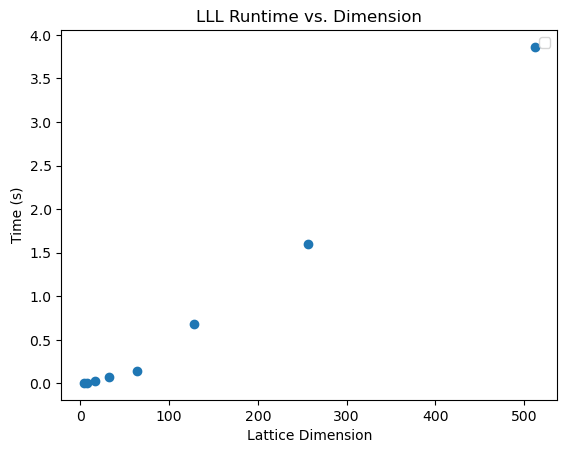

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


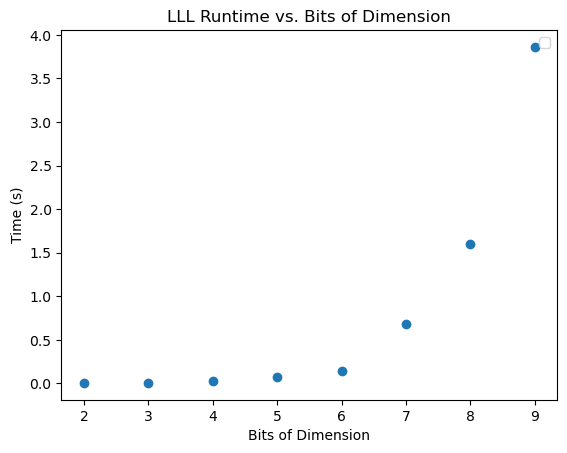

In [143]:
plotTimeData(LLLOptimized)